## Exercise 4.10: Coding Etiquette & Excel Reporting

This notebook contains the task work for Exercise 4.10. The objective is applying coding etiquette regarding personal privacy of individuals when profiling datasets.

# Step 1: Importing relevant libraries and dataset

In [61]:
# Import core libraries
import pandas as pd
import numpy as np
import os

In [62]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
# Set project path
path = r'/Users/jessduong/Documents/CF/Achievement 4_Python/12-2025 Instacart Basket Analysis_Jessica_Duong'

In [64]:
# Load the merged dataset from Exercise 4.9
df = pd.read_pickle(os.path.join(path, "02 Data", "Prepared Data", "ords_prods_cust.pkl"))

In [65]:
# Quick check dataset
df.shape

(32435059, 35)

In [66]:
# Column name quick check 
df.head()

,order_id,user_id,eval_set,order_number,orders_day_of_week,order_hour_of_day,days_since_previous_order,first_order_flag,product_id,add_to_cart_order,...,median_days_since_prior_order,first_name,surname,gender,state,age,date_joined,n_dependents,family_status,income
0,2539329,1,prior,1,2,8,0.0,True,196,1,...,20.0,Linda,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
1,2539329,1,prior,1,2,8,0.0,True,14084,2,...,20.0,Linda,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
2,2539329,1,prior,1,2,8,0.0,True,12427,3,...,20.0,Linda,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
3,2539329,1,prior,1,2,8,0.0,True,26088,4,...,20.0,Linda,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423
4,2539329,1,prior,1,2,8,0.0,True,26405,5,...,20.0,Linda,Nguyen,Female,Alabama,31,2019-02-17,3,married,40423


# Step 2: PII handling 

In [67]:
# List columns to review for PII
df.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'orders_day_of_week',
       'order_hour_of_day', 'days_since_previous_order', 'first_order_flag',
       'product_id', 'add_to_cart_order', 'reordered', 'product_name',
       'aisle_id', 'department_id', 'prices', 'price_range_loc', 'busiest_day',
       'busiest_days_2', 'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'mean_price_user', 'spending_flag', 'median_days_since_order',
       'order_frequency_flag', 'median_days_since_prior_order', 'first_name',
       'surname', 'gender', 'state', 'age', 'date_joined', 'n_dependents',
       'family_status', 'income'],
      dtype='object')

In [68]:
# Copy to preserve the original df
df_safe = df.copy()

In [69]:
# Confirming what in first name and surname fields quick check
df[['first_name','surname']].head()
df[['first_name','surname']].isna().sum()

first_name    0
surname       0
dtype: int64

In [70]:
# Drop first name and surname columns
df_safe = df_safe.drop(columns=['first_name', 'surname'])

In [71]:
# Checking column name and shape after dropping PII data
df_safe.columns
df_safe.shape

(32435059, 33)

In [72]:
# Lock cleaned dataset
df_safe.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "ords_prods_cust_no_pii.pkl"))

**PII check**: Customer name fields (first_name, surname) were present in the merged dataset. These columns were removed before analysis to reduce er-identification risk. Other customer attributes (e.g., age, state, gender, income) were retained as they are used for segmentation and are not direct identifiers in this context.

# Step 3: Creating regional segmentation

In [73]:
# Census Bureau Region Mapping

In [74]:
northeast = ['ME','NH','VT','MA','RI','CT','NY','PA','NJ']

In [75]:
midwest = ['WI','MI','IL','IN','OH','ND','SD','NE','KS','MN','IA','MO']

In [76]:
south = ['DE','MD','DC','VA','WV','NC','SC','GA','FL', 'KY','TN','MS','AL', 'OK','TX','AR','LA']

In [77]:
west = ['ID','MT','WY','NV','UT','CO','AZ','NM', 'AK','WA','OR','CA','HI']

In [78]:
# Assign region names
def assign_region(state):
    if state in northeast: return 'Northeast'
    elif state in midwest: return 'Midwest'
    elif state in south: return 'South'
    elif state in west: return 'West'
    else: return 'Unknown'

In [79]:
# Create census-based regional segmentation (state → region)
# Map each customer to one of four U.S. Census regions
df_safe['region'] = df_safe['state'].apply(assign_region)

In [80]:
# Validate
df_safe['region'].value_counts()

region
Unknown    32435059
Name: count, dtype: int64

After assigning the regions, I am getting 32435059 unknowns. This may be because the state column is not using two-letter codes so every row is failing the lookup and falling into unknown.

In [81]:
# Checking state names in dataset
df_safe['state'].head(10)

0    Alabama
1    Alabama
2    Alabama
3    Alabama
4    Alabama
5    Alabama
6    Alabama
7    Alabama
8    Alabama
9    Alabama
Name: state, dtype: object

In [82]:
# Abbreviating state names to 2-letter code for standardization
state_abbrev = {'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA','Colorado':'CO', 
                'Connecticut':'CT','Delaware':'DE','District of Columbia':'DC','Florida':'FL','Georgia':'GA', 
                'Hawaii':'HI','Idaho':'ID','Illinois':'IL','Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY',
                'Louisiana':'LA','Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN', 
                'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV','New Hampshire':'NH',
                'New Jersey':'NJ','New Mexico':'NM','New York':'NY','North Carolina':'NC','North Dakota':'ND',
                'Ohio': 'OH','Oklahoma':'OK','Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI',
                'South Carolina':'SC','South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
                'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY'}

In [83]:
# Normalize state names to USPS 2-letter abbreviations
df_safe['state_abbrev'] = df_safe['state'].map(state_abbrev)

In [84]:
# Quick validation (How many rows failed to map to a valid state abbreviation?)
df_safe[['state','state_abbrev']].head(10)
df_safe['state_abbrev'].isna().sum()

np.int64(0)

Zero rows failed to map a valid state abbreviation, therefore every 32,435,059 customers now has a valid state code.

In [85]:
# Create Census-based regional segmentation
# Northeast, Midwest, South, West
df_safe['region'] = df_safe['state_abbrev'].apply(assign_region)

In [86]:
# Validate regional distribution
# distribution by geographic market
df_safe['region'].value_counts()

region
South        10801982
West          8300617
Midwest       7604016
Northeast     5728444
Name: count, dtype: int64

Value counts gives size of Instacart's geographic markets. The south is IC's largest market, and the North is the smallest market. 

# Step 4: Exclude low-activity customers (<5 orders)

In [87]:
# Identify low-activity customers (CFO relevance filter)
# Customers with fewer than 5 lifetime orders are flagged
df_safe['low_activity_flag'] = np.where(df_safe['max_order'] < 5, 1, 0)

In [88]:
# Validate low_activity_flag
df_safe['low_activity_flag'].value_counts()

low_activity_flag
0    30993489
1     1441570
Name: count, dtype: int64

30,993,489 rows of revenue-relevant customers
1,441,570 rows of low-activity customers removed (~4.4% of dataset)

In [89]:
# Create CFO-relevant customer dataset
# Removes low-activity customers (fewer than 5 lifetime orders)
df_cfo = df_safe[df_safe['low_activity_flag'] == 0]

In [90]:
# Validate resulting dataset shape
df_cfo.shape

(30993489, 36)

In [91]:
# Export CFO-relevant dataset for downstream analysis and reporting
df_cfo.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "ords_prods_cust_cfo.pkl"))

# Low-Activity Customer Exclusion (CFO Relevance Filter)

Customers with fewer than five lifetime orders were flagged and excluded from the CFO-level analysis. This step removed low-engagement users that generate minimal revenue and focuses all subsequent segmentation and visual analysis on economically meaningful customers.

# Step 5: Building customer profiling segments
In this section, we are going to create profiling labesl such as:
Young Single
Young Parent
Older Family
High-Income Professional

**Step 5a: Create Age Groups**

In [92]:
# Standardize age column to numeric for binning
df_cfo['age'] = pd.to_numeric(df_cfo['age'], errors='coerce')

/var/folders/85/2tfx5b95721gp7lbbkvhcplw0000gn/T/ipykernel_1162/471435003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cfo['age'] = pd.to_numeric(df_cfo['age'], errors='coerce')


In [93]:
# Create CFO-relevant dataset (exclude low-activity customers) and lock it as a standalone copy
df_cfo = df_safe.loc[df_safe['low_activity_flag'] == 0].copy()

In [94]:
# Quick check
df_cfo['age'].dtype
df_cfo['age'].isna().sum()
df_cfo['age'].describe()

count    3.099349e+07
mean     4.946786e+01
std      1.848521e+01
min      1.800000e+01
25%      3.300000e+01
50%      4.900000e+01
75%      6.500000e+01
max      8.100000e+01
Name: age, dtype: float64

In [95]:
# Create 3 age groups - 4 bin edges for 3 groups
# 3 intervals: (17–29], (29–44], (44–100]
age_bins = [17, 29, 44, 100]  
age_labels = ['Young Adult', 'Middle-Aged Adult', 'Older Adult']

df_cfo['age_group'] = pd.cut(df_cfo['age'], bins=age_bins, labels=age_labels, include_lowest=True)

In [96]:
# Validate the distribution (include NaNs if any)
df_cfo['age_group'].value_counts(dropna=False)

age_group
Older Adult          17902450
Middle-Aged Adult     7267849
Young Adult           5823190
Name: count, dtype: int64

I created an age-based customer profile segments using 3 age brackets for  downstream  profiling and comparisons.

**Step 5b**: Create household/family status

In [97]:
# Create household/family status segmentation
# Customers with 1+ dependents are treated as "Family"
# Customers with 0 dependents are treated as "Single"
df_cfo['family_status'] = np.where(df_cfo['n_dependents'] > 0, 'Family', 'Single')

In [98]:
# Validate
df_cfo['family_status'].value_counts()

family_status
Family    23246306
Single     7747183
Name: count, dtype: int64

The value_counts() tells how many rows (orders/line-items) in the CFO dataset belong to each household type:
family = 23,246,306 rows
Single = 7,747,183 rows
So in the CFO-filtered dataset, the majority of activity is coming from customers with 1+ dependents.

df_cfo is merged, order-product-level dataset, these counts are NOT the number of unique customers.
They’re counts of rows, meaning how much “shopping activity” each group contributes.

In [99]:
# Unique customers by family_status (true customer counts)
df_cfo.groupby('family_status')['user_id'].nunique()

family_status
Family    121905
Single     40728
Name: user_id, dtype: int64

For unique customers:
121,905 Family customers
40,728 Single customers

~75% of Instacart’s revenue-relevant customer base are family households
Families also generate the majority of order-line activity

**Step 5c**: Income tiering

Creating the demographic triad: Age x Family x Income

In [100]:
# Create income groups (tiers) for customer profiling
# Segment customers into 3 income bands
income_bins = [0, 60000, 120000, df_cfo['income'].max()]
income_labels = ['Low Income', 'Middle Income', 'High Income']

In [101]:
df_cfo['income_group'] = pd.cut( df_cfo['income'], bins=income_bins, labels=income_labels, include_lowest=True)

In [102]:
# Validate income segmentation
df_cfo['income_group'].value_counts(dropna=False)

income_group
Middle Income    15996669
High Income       9187614
Low Income        5809206
Name: count, dtype: int64

Middle Income = dominant revenue engine
High Income = meaningful premium expansion opportunity
Low Income = smaller but strategic retention & accessibility segment

[0-60K] Low Income  
[60k-120k] Middle Income 
[120k-max] High Income

**Step 5d**: Build department-based shopper profile

The goal is to collapse millions of product-level rows into clear shopper identities based on what people actually buy.

Create new column: shopper_profile

First, create department buckets.

In [103]:
# Fix: rebuild a clean departments lookup + merge onto df_cfo
# 1) Load departments.csv
departments_raw = pd.read_csv(os.path.join(path, "02 Data", "Original Data", "departments.csv"))

In [104]:
# 2) Convert to a clean 2-column lookup no matter what shape it's in
if set(["department_id", "department"]).issubset(departments_raw.columns):
    departments_clean = departments_raw[["department_id", "department"]].drop_duplicates("department_id").copy()
else:
    dept_series = departments_raw.drop(columns=["department_id"], errors="ignore").iloc[0]
    departments_clean = dept_series.reset_index()
    departments_clean.columns = ["department_id", "department"]
    departments_clean["department_id"] = departments_clean["department_id"].astype(int)

In [105]:
# 3) Merge department names onto df_cfo
df_cfo = df_cfo.merge(departments_clean, on="department_id", how="left")

In [106]:
# 4) Quick check
print("department in df_cfo:", "department" in df_cfo.columns)
print("missing department names:", df_cfo["department"].isna().sum())

department in df_cfo: True
missing department names: 28919


In [107]:
# 0) Hard stop if df_cfo isn't present
if "df_cfo" not in globals():
    raise NameError("df_cfo not found. Re-run Step 4 where you create df_cfo.")

In [108]:
# 1) Ensure ONE clean department column
if "department" not in df_cfo.columns:
    if "department_y" in df_cfo.columns or "department_x" in df_cfo.columns:
        df_cfo["department"] = df_cfo.get("department_y").combine_first(df_cfo.get("department_x"))
        df_cfo = df_cfo.drop(columns=[c for c in ["department_x", "department_y"] if c in df_cfo.columns])
    else:
        raise KeyError("No 'department' column found. You need the department merge step BEFORE Step 5d.")

In [109]:
# 2) Define department buckets (lowercase, exact matches)
health_depts      = ["produce", "dairy eggs"]
family_depts      = ["pantry", "frozen", "dairy eggs"]
convenience_depts = ["frozen", "deli", "bakery"]
snack_depts       = ["snacks", "beverages"]
household_depts   = ["household", "personal care", "babies"]

In [110]:
# 3) Classifier function
def assign_shopper_profile(dept):
    # Handle missing safely
    if pd.isna(dept):
        return "Unknown / Missing Dept"

    dept = str(dept).strip().lower()

    if dept in health_depts:
        return "Health-Focused Shopper"
    elif dept in family_depts:
        return "Family Stock-Up Shopper"
    elif dept in convenience_depts:
        return "Convenience Shopper"
    elif dept in snack_depts:
        return "Snack & Beverage Shopper"
    elif dept in household_depts:
        return "Household Essentials Shopper"
    else:
        return "Mixed / Other Shopper"

In [111]:
# Fix: One clean 'department' column (handles department_x/department_y cases)
if "department" not in df_cfo.columns:
    df_cfo["department"] = df_cfo.get("department_y").combine_first(df_cfo.get("department_x"))

In [112]:
# 4) Create shopper_profile column
df_cfo["shopper_profile"] = df_cfo["department"].apply(assign_shopper_profile)

In [113]:
# Validation
df_cfo["shopper_profile"].value_counts(dropna=False)

shopper_profile
Health-Focused Shopper          14256459
Snack & Beverage Shopper         5338307
Family Stock-Up Shopper          3904437
Mixed / Other Shopper            3806149
Convenience Shopper              2124662
Household Essentials Shopper     1534556
Unknown / Missing Dept             28919
Name: count, dtype: int64

In [114]:
# Missing department flag
df_cfo["missing_department_flag"] = np.where(df_cfo["department"].isna(), 1, 0)
df_cfo["missing_department_flag"].value_counts()

missing_department_flag
0    30964570
1       28919
Name: count, dtype: int64

In [115]:
# Check to see what columns are there
[c for c in df_cfo.columns if "depart" in c]

['department_id', 'department', 'missing_department_flag']

In [116]:
# Re-export data set
df_cfo.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "ords_prods_cust_cfo.pkl"))

**Step 5e**: Compound customer personas

In [117]:
# Build compound customer persona (Age × Family × Income × Behavior)
df_cfo['compound_persona'] = (df_cfo['age_group'].astype(str) + " | " +
    df_cfo['family_status'].astype(str) + " | " +
    df_cfo['income_group'].astype(str) + " | " +
    df_cfo['shopper_profile'].astype(str))

In [118]:
# How many compound personas exist?
df_cfo['compound_persona'].nunique()

126

In [119]:
# Top compound personas by order-line volume
df_cfo['compound_persona'].value_counts().head(15)

compound_persona
Older Adult | Family | High Income | Health-Focused Shopper            2839558
Older Adult | Family | Middle Income | Health-Focused Shopper          2732286
Middle-Aged Adult | Family | Middle Income | Health-Focused Shopper    1551410
Young Adult | Family | Middle Income | Health-Focused Shopper          1377661
Older Adult | Single | High Income | Health-Focused Shopper             966056
Older Adult | Family | High Income | Snack & Beverage Shopper           953930
Older Adult | Family | Middle Income | Snack & Beverage Shopper         914499
Older Adult | Single | Middle Income | Health-Focused Shopper           905641
Older Adult | Family | High Income | Family Stock-Up Shopper            783807
Older Adult | Family | High Income | Mixed / Other Shopper              774972
Older Adult | Family | Middle Income | Family Stock-Up Shopper          745220
Older Adult | Family | Middle Income | Mixed / Other Shopper            733177
Middle-Aged Adult | Family | Low In

In [120]:
# Unique customer count per compound persona
df_cfo.groupby('compound_persona')['user_id'].nunique().sort_values(ascending=False).head(15)

compound_persona
Older Adult | Family | High Income | Health-Focused Shopper              30009
Older Adult | Family | High Income | Snack & Beverage Shopper            29322
Older Adult | Family | High Income | Family Stock-Up Shopper             29256
Older Adult | Family | High Income | Mixed / Other Shopper               28895
Older Adult | Family | Middle Income | Health-Focused Shopper            28339
Older Adult | Family | Middle Income | Snack & Beverage Shopper          27702
Older Adult | Family | Middle Income | Family Stock-Up Shopper           27591
Older Adult | Family | Middle Income | Mixed / Other Shopper             27296
Older Adult | Family | High Income | Convenience Shopper                 26729
Older Adult | Family | Middle Income | Convenience Shopper               25314
Older Adult | Family | High Income | Household Essentials Shopper        23334
Older Adult | Family | Middle Income | Household Essentials Shopper      21939
Middle-Aged Adult | Family | Middle

**Step 5f**: Strategic revenue segmentation

In [121]:
# Step 5f: Create revenue tiers (CFO segmentation)
# Use quartiles of mean_price_user to create 4 revenue-intensity tiers
rev_bins = df_cfo['mean_price_user'].quantile([0, .25, .5, .75, 1]).values
rev_labels = ['Low Value', 'Mid Value', 'High Value', 'Premium Value']

In [122]:
# Assign each row to a revenue tier based on the user's average spend metric
df_cfo['revenue_tier'] = pd.cut(df_cfo['mean_price_user'], bins=rev_bins, labels=rev_labels, include_lowest=True)

In [123]:
# Validation: distribution of rows across revenue tiers
# df_cfo is order-product level, so these are row counts (activity volume), not unique customers
df_cfo['revenue_tier'].value_counts()

revenue_tier
Low Value        7748475
High Value       7748424
Mid Value        7748304
Premium Value    7748286
Name: count, dtype: int64

In [124]:
# Validation: unique customer counts per revenue tier (true customer segmentation)
df_cfo.groupby('revenue_tier')['user_id'].nunique().sort_values(ascending=False)

/var/folders/85/2tfx5b95721gp7lbbkvhcplw0000gn/T/ipykernel_1162/113619829.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cfo.groupby('revenue_tier')['user_id'].nunique().sort_values(ascending=False)


revenue_tier
Low Value        48934
Premium Value    45976
Mid Value        33980
High Value       33743
Name: user_id, dtype: int64

Low Value = 48,934
Premium Value = 45,976
Mid Value = 33,980
High Value = 33,743
Total revenue-relevant customers ≈ 162,633

Low-value and premium segments contain more customers.
High and mid tiers are smaller but more intense buyers.

Instacart has a barbell revenue structure:
Large base of low spenders. 
Large base of premium spenders. 
Smaller, high-efficiency middle core.

**Revenue tiers were created using quartiles of each customer's average spend (mean_price_user), ensuring balanced segmentation based on real spending behavior. Although activity volume is evenly distributed across tiers, customer distribution is not. Low Value (48,934 customers) and Premium Value (45,976 customers) segments contain the largest customer bases, while Mid and High Value tiers represent smaller but more concentrated spend groups. This reveals a barbell-shaped revenue structure, with opportunities to upsell low-value users and retain premium customers as primary revenue drivers.**

**Step 5g**: Revenue dominance by compound persona

Goal is to identify which compound personas generate the most total revenue (based on prices). This supports marketing strategy + budget allocation (focus on highest revenue personas). 

df_cfo is order-product level, so we aggregate to persona level using groupby + sum

In [125]:
# 1) Sum total revenue (prices) per compound persona
persona_revenue = (
    df_cfo.groupby('compound_persona')['prices'].sum().sort_values(ascending=False).reset_index())                     

In [126]:
# 2) Rename columns for clarity
persona_revenue.columns = ['compound_persona', 'total_revenue']

In [127]:
# 3) Validation: show the top 10 revenue-generating personas
persona_revenue.head(10)

,compound_persona,total_revenue
0,Older Adult | Family | High Income | Health-Fo...,23321788.2
1,Older Adult | Family | Middle Income | Health-...,22465470.6
2,Middle-Aged Adult | Family | Middle Income | H...,12740600.4
3,Young Adult | Family | Middle Income | Health-...,11330900.6
4,Older Adult | Single | High Income | Health-Fo...,7959912.2
5,Older Adult | Single | Middle Income | Health-...,7453912.5
6,Older Adult | Family | High Income | Mixed / O...,7263759.7
7,Older Adult | Family | Middle Income | Mixed /...,6873196.4
8,Older Adult | Family | High Income | Family St...,6221224.2
9,Older Adult | Family | Middle Income | Family ...,5920915.6


**Step 5h**: Revenue concentration (who actually matters)

Goal is to determine how concentrated Instacart revenue is across personas. This helps decide whether marketing should be broad or sharply targeted

In [128]:
# 1) Calculate total platform revenue
total_revenue = persona_revenue['total_revenue'].sum()

In [129]:
# 2) Compute each persona's revenue share
persona_revenue['revenue_share_pct'] = (persona_revenue['total_revenue'] / total_revenue * 100)

In [130]:
# 3) Calculate cumulative revenue share (Pareto curve)
persona_revenue['cumulative_revenue_pct'] = (persona_revenue['revenue_share_pct'].cumsum())

In [131]:
# 4) Quick check: show top 15 personas and how much revenue they control
persona_revenue.head(15)

,compound_persona,total_revenue,revenue_share_pct,cumulative_revenue_pct
0,Older Adult | Family | High Income | Health-Fo...,23321788.2,9.669295,9.669295
1,Older Adult | Family | Middle Income | Health-...,22465470.6,9.314263,18.983559
2,Middle-Aged Adult | Family | Middle Income | H...,12740600.4,5.282298,24.265856
3,Young Adult | Family | Middle Income | Health-...,11330900.6,4.697831,28.963688
4,Older Adult | Single | High Income | Health-Fo...,7959912.2,3.300208,32.263895
5,Older Adult | Single | Middle Income | Health-...,7453912.5,3.090418,35.354314
6,Older Adult | Family | High Income | Mixed / O...,7263759.7,3.011580,38.365894
7,Older Adult | Family | Middle Income | Mixed /...,6873196.4,2.849651,41.215545
8,Older Adult | Family | High Income | Family St...,6221224.2,2.579341,43.794887
9,Older Adult | Family | Middle Income | Family ...,5920915.6,2.454832,46.249719


**Step 5i**: Define Strategic Marketing Segments

The goal is to classify personas into actionable marketing priority tiers

In [132]:
def classify_marketing_priority(cum_pct):
    if cum_pct <= 50: return 'Tier 1 – Core Revenue Drivers'
    elif cum_pct <= 80: return 'Tier 2 – Growth Opportunity'
    else: return 'Tier 3 – Long-Tail Support'

In [133]:
persona_revenue['marketing_priority'] = persona_revenue['cumulative_revenue_pct'].apply(classify_marketing_priority)

In [134]:
# Preview marketing tiers
persona_revenue.head(20)

,compound_persona,total_revenue,revenue_share_pct,cumulative_revenue_pct,marketing_priority
0,Older Adult | Family | High Income | Health-Fo...,23321788.2,9.669295,9.669295,Tier 1 – Core Revenue Drivers
1,Older Adult | Family | Middle Income | Health-...,22465470.6,9.314263,18.983559,Tier 1 – Core Revenue Drivers
2,Middle-Aged Adult | Family | Middle Income | H...,12740600.4,5.282298,24.265856,Tier 1 – Core Revenue Drivers
3,Young Adult | Family | Middle Income | Health-...,11330900.6,4.697831,28.963688,Tier 1 – Core Revenue Drivers
4,Older Adult | Single | High Income | Health-Fo...,7959912.2,3.300208,32.263895,Tier 1 – Core Revenue Drivers
5,Older Adult | Single | Middle Income | Health-...,7453912.5,3.090418,35.354314,Tier 1 – Core Revenue Drivers
6,Older Adult | Family | High Income | Mixed / O...,7263759.7,3.011580,38.365894,Tier 1 – Core Revenue Drivers
7,Older Adult | Family | Middle Income | Mixed /...,6873196.4,2.849651,41.215545,Tier 1 – Core Revenue Drivers
8,Older Adult | Family | High Income | Family St...,6221224.2,2.579341,43.794887,Tier 1 – Core Revenue Drivers
9,Older Adult | Family | Middle Income | Family ...,5920915.6,2.454832,46.249719,Tier 1 – Core Revenue Drivers


**Step 5j**: Attach marketing strategy playbooks to each tier

Goal is to translate segmentation into real-world marketing actions

In [135]:
def assign_marketing_strategy(tier):
    if tier == 'Tier 1 – Core Revenue Drivers': return 'Protect & Expand – loyalty rewards, premium bundles, subscription lock-in'
    elif tier == 'Tier 2 – Growth Opportunity': return 'Upsell & Nurture – targeted promotions, bundle incentives, habit building'
    else: return 'Low-Cost Retention – automated promos, email-only campaigns'

In [136]:
persona_revenue['marketing_strategy'] = persona_revenue['marketing_priority'].apply(assign_marketing_strategy)

In [137]:
# Preview final strategic persona framework
persona_revenue.head(20)

,compound_persona,total_revenue,revenue_share_pct,cumulative_revenue_pct,marketing_priority,marketing_strategy
0,Older Adult | Family | High Income | Health-Fo...,23321788.2,9.669295,9.669295,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
1,Older Adult | Family | Middle Income | Health-...,22465470.6,9.314263,18.983559,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
2,Middle-Aged Adult | Family | Middle Income | H...,12740600.4,5.282298,24.265856,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
3,Young Adult | Family | Middle Income | Health-...,11330900.6,4.697831,28.963688,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
4,Older Adult | Single | High Income | Health-Fo...,7959912.2,3.300208,32.263895,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
5,Older Adult | Single | Middle Income | Health-...,7453912.5,3.090418,35.354314,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
6,Older Adult | Family | High Income | Mixed / O...,7263759.7,3.011580,38.365894,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
7,Older Adult | Family | Middle Income | Mixed /...,6873196.4,2.849651,41.215545,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
8,Older Adult | Family | High Income | Family St...,6221224.2,2.579341,43.794887,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."
9,Older Adult | Family | Middle Income | Family ...,5920915.6,2.454832,46.249719,Tier 1 – Core Revenue Drivers,"Protect & Expand – loyalty rewards, premium bu..."


**Step 5k**: Tier-level revenue concentration summary

The purpose is to create clean, visualization-ready tables for Step 6 dashboards

In [138]:
tier_summary = (persona_revenue.groupby('marketing_priority').agg(personas=('compound_persona', 'nunique'), total_revenue=('total_revenue', 'sum'), avg_revenue_share_pct=('revenue_share_pct', 'mean'), max_cumulative_revenue_pct=('cumulative_revenue_pct', 'max')).reset_index())

tier_summary

,marketing_priority,personas,total_revenue,avg_revenue_share_pct,max_cumulative_revenue_pct
0,Tier 1 – Core Revenue Drivers,11,117401223.7,4.424996,48.674961
1,Tier 2 – Growth Opportunity,23,73784464.2,1.330056,79.266259
2,Tier 3 – Long-Tail Support,92,50008597.9,0.225367,100.000000


11 personas generate almost HALF of all revenue.
34 personas generate ~80% of revenue.
The remaining 74 personas collectively generate only ~20%.

**Step 5l**: Executive demographic composition by marketing tier

The purpose is to understand WHO makes up each tier demographically

In [139]:
tier_composition = (persona_revenue.groupby(['marketing_priority', 'compound_persona']).agg(total_revenue=('total_revenue', 'sum')).reset_index().sort_values(['marketing_priority', 'total_revenue'], ascending=[True, False]))

In [140]:
# Check
tier_composition.head(15)

,marketing_priority,compound_persona,total_revenue
2,Tier 1 – Core Revenue Drivers,Older Adult | Family | High Income | Health-Fo...,23321788.2
6,Tier 1 – Core Revenue Drivers,Older Adult | Family | Middle Income | Health-...,22465470.6
0,Tier 1 – Core Revenue Drivers,Middle-Aged Adult | Family | Middle Income | H...,12740600.4
10,Tier 1 – Core Revenue Drivers,Young Adult | Family | Middle Income | Health-...,11330900.6
8,Tier 1 – Core Revenue Drivers,Older Adult | Single | High Income | Health-Fo...,7959912.2
9,Tier 1 – Core Revenue Drivers,Older Adult | Single | Middle Income | Health-...,7453912.5
3,Tier 1 – Core Revenue Drivers,Older Adult | Family | High Income | Mixed / O...,7263759.7
7,Tier 1 – Core Revenue Drivers,Older Adult | Family | Middle Income | Mixed /...,6873196.4
1,Tier 1 – Core Revenue Drivers,Older Adult | Family | High Income | Family St...,6221224.2
5,Tier 1 – Core Revenue Drivers,Older Adult | Family | Middle Income | Family ...,5920915.6


**Step 5m**: Break Tier 1 personas into clean demographic slices

The purpose is to quantify which AGE groups, FAMILY status, and INCOME bands dominate Tier 1 revenue

In [141]:
tier1_demo = (tier_composition[tier_composition['marketing_priority'] == 'Tier 1 – Core Revenue Drivers'].assign(age_group=lambda x: x['compound_persona'].str.split(' \| ').str[0],family_status=lambda x: x['compound_persona'].str.split(' \| ').str[1], income_group=lambda x: x['compound_persona'].str.split(' \| ').str[2], behavior=lambda x: x['compound_persona'].str.split(' \| ').str[3]))

In [142]:
# Check
tier1_demo.head(10)

,marketing_priority,compound_persona,total_revenue,age_group,family_status,income_group,behavior
2,Tier 1 – Core Revenue Drivers,Older Adult | Family | High Income | Health-Fo...,23321788.2,Older Adult,Family,High Income,Health-Focused Shopper
6,Tier 1 – Core Revenue Drivers,Older Adult | Family | Middle Income | Health-...,22465470.6,Older Adult,Family,Middle Income,Health-Focused Shopper
0,Tier 1 – Core Revenue Drivers,Middle-Aged Adult | Family | Middle Income | H...,12740600.4,Middle-Aged Adult,Family,Middle Income,Health-Focused Shopper
10,Tier 1 – Core Revenue Drivers,Young Adult | Family | Middle Income | Health-...,11330900.6,Young Adult,Family,Middle Income,Health-Focused Shopper
8,Tier 1 – Core Revenue Drivers,Older Adult | Single | High Income | Health-Fo...,7959912.2,Older Adult,Single,High Income,Health-Focused Shopper
9,Tier 1 – Core Revenue Drivers,Older Adult | Single | Middle Income | Health-...,7453912.5,Older Adult,Single,Middle Income,Health-Focused Shopper
3,Tier 1 – Core Revenue Drivers,Older Adult | Family | High Income | Mixed / O...,7263759.7,Older Adult,Family,High Income,Mixed / Other Shopper
7,Tier 1 – Core Revenue Drivers,Older Adult | Family | Middle Income | Mixed /...,6873196.4,Older Adult,Family,Middle Income,Mixed / Other Shopper
1,Tier 1 – Core Revenue Drivers,Older Adult | Family | High Income | Family St...,6221224.2,Older Adult,Family,High Income,Family Stock-Up Shopper
5,Tier 1 – Core Revenue Drivers,Older Adult | Family | Middle Income | Family ...,5920915.6,Older Adult,Family,Middle Income,Family Stock-Up Shopper


**Step 5n**: Tier 1 revenue dominance by AGE GROUP

The purpose is to identify which age segments actually generate Tier-1 revenue

In [143]:
tier1_age_dominance = (tier1_demo.groupby('age_group').agg(total_revenue=('total_revenue', 'sum'), personas=('compound_persona', 'nunique')).sort_values('total_revenue', ascending=False).reset_index())

In [144]:
tier1_age_dominance

,age_group,total_revenue,personas
0,Older Adult,93329722.7,9
1,Middle-Aged Adult,12740600.4,1
2,Young Adult,11330900.6,1


**Step 5o**: Tier 1 revenue dominance by FAMILY STATUS

The purpose is to identify whether families or singles truly fund Tier-1 revenue

In [145]:
tier1_family_dominance = (tier1_demo.groupby('family_status').agg(total_revenue=('total_revenue', 'sum'), personas=('compound_persona', 'nunique')).sort_values('total_revenue', ascending=False).reset_index())

In [146]:
# Check
tier1_family_dominance

,family_status,total_revenue,personas
0,Family,101987399.0,9
1,Single,15413824.7,2


**Step 5p**: Tier 1 revenue dominance by INCOME GROUP

The purpose is to identify which income tier actually funds Tier-1 revenue

In [147]:
tier1_income_dominance = (tier1_demo.groupby('income_group').agg(total_revenue=('total_revenue', 'sum'), personas=('compound_persona', 'nunique')).sort_values('total_revenue', ascending=False).reset_index())

In [148]:
# Check
tier1_income_dominance

,income_group,total_revenue,personas
0,Middle Income,66784996.1,6
1,High Income,50616227.6,5


**Steo 5q**: What departments fund Tier-1 revenue

The purpose is to identify which product categories actually generate Tier-1 money

In [152]:
# Merge left
df_cfo = df_cfo.merge(persona_revenue[['compound_persona', 'marketing_priority']], on='compound_persona', how='left')

In [155]:
# Check what marketing_priority columns exist after merge
marketing_cols = [col for col in df_cfo.columns if 'marketing_priority' in col]
print("Marketing priority columns:", marketing_cols)

Marketing priority columns: ['marketing_priority']


In [158]:
# Handle based on what exists
if 'marketing_priority_y' in df_cfo.columns:
    df_cfo["marketing_priority"] = df_cfo["marketing_priority_y"]
    df_cfo = df_cfo.drop(columns=["marketing_priority_x", "marketing_priority_y"])
    print("Cleaned up _x and _y columns")
elif 'marketing_priority' in df_cfo.columns:
    print("marketing_priority already exists - no cleanup needed")
else:
    print("WARNING: marketing_priority column not found!")

marketing_priority already exists - no cleanup needed


In [159]:
# Verify
print(df_cfo['marketing_priority'].value_counts())

marketing_priority
Tier 1 – Core Revenue Drivers    14363718
Tier 2 – Growth Opportunity       9793283
Tier 3 – Long-Tail Support        6836488
Name: count, dtype: int64


**Step 5r**: Tier 1 department dominance

The goal is within Tier 1 (Core Revenue Drivers), identify which departments generate the most revenue.

Note: df_cfo is order-line level, so:
total_revenue = sum of prices across order-lines and order_lines = number of rows (shopping activity volume)

In [160]:
tier1_department_dominance = (df_cfo[df_cfo['marketing_priority'] == 'Tier 1 – Core Revenue Drivers'].groupby('department').agg(total_revenue=('prices', 'sum'),order_lines=('prices', 'count')).sort_values('total_revenue', ascending=False).reset_index())

In [161]:
# Check: top 15 departments funding Tier 1 revenue
tier1_department_dominance.head(15)

,department,total_revenue,order_lines
0,produce,53539003.1,6625921
1,dairy eggs,31733581.4,3743545
2,frozen,6479132.0,828276
3,pantry,5663007.8,700751
4,meat seafood,4626753.4,282498
5,beverages,3828814.9,483854
6,canned goods,3100318.5,407036
7,dry goods pasta,2441184.2,329543
8,breakfast,2032149.5,247640
9,snacks,2020728.4,470076


**Step 5s**: Tier 2 department dominance

The goal is to identify which departments fund Tier 2 (Growth Opportunity) revenue.

In [162]:
tier2_department_dominance = (df_cfo[df_cfo['marketing_priority'] == 'Tier 2 – Growth Opportunity'].groupby('department').agg(total_revenue=('prices', 'sum'),order_lines=('prices', 'count')).sort_values('total_revenue', ascending=False).reset_index())

In [163]:
# Check: top 15 departments funding Tier 2 revenue
tier2_department_dominance.head(15)

,department,total_revenue,order_lines
0,produce,15384809.1,1988504
1,beverages,9882370.0,1282692
2,dairy eggs,9205069.0,1149604
3,snacks,5874040.9,1371745
4,frozen,5500729.1,702410
5,pantry,4831240.0,597778
6,meat seafood,3886505.5,237683
7,bakery,3495864.5,438289
8,deli,3061324.6,386097
9,canned goods,2598271.9,342803


**Step 5t** : Label Tier 2 departments as CORE vs ADD-ON categories

In [164]:
core_departments = ['produce', 'dairy eggs', 'frozen', 'pantry', 'meat seafood', 'canned goods', 'dry goods pasta', 'breakfast']

tier2_department_dominance['category_type'] = tier2_department_dominance['department'].apply(lambda x: 'Core Food' if x in core_departments else 'Add-On / Discretionary')

In [165]:
# Revenue split by core vs add-on
tier2_core_vs_addon = (tier2_department_dominance.groupby('category_type').agg(total_revenue=('total_revenue', 'sum'),order_lines=('order_lines', 'sum')).reset_index())

In [166]:
# Check
tier2_core_vs_addon

,category_type,total_revenue,order_lines
0,Add-On / Discretionary,28561923.1,4281327
1,Core Food,45222541.1,5511199


**Step 5u**: Which personas fund Add-On Tier-2 growth?

In [167]:
tier2_addon_personas = (df_cfo[
        (df_cfo['marketing_priority'] == 'Tier 2 – Growth Opportunity') &
        (df_cfo['department'].isin(tier2_department_dominance.query("category_type == 'Add-On / Discretionary'")['department']))
    ].groupby('compound_persona').agg(total_revenue=('prices', 'sum'),order_lines=('prices', 'count')).sort_values('total_revenue', ascending=False).reset_index())

In [168]:
tier2_addon_personas.head(15)

,compound_persona,total_revenue,order_lines
0,Older Adult | Family | Middle Income | Snack &...,5569646.7,914499
1,Older Adult | Family | High Income | Convenien...,3349097.4,422545
2,Older Adult | Family | Middle Income | Conveni...,3208091.7,401841
3,Middle-Aged Adult | Family | Middle Income | S...,3128715.2,512086
4,Young Adult | Family | Middle Income | Snack &...,2716018.0,446456
5,Older Adult | Family | High Income | Household...,2348353.8,304898
6,Older Adult | Family | Low Income | Snack & Be...,2339267.3,454052
7,Older Adult | Family | Middle Income | Househo...,2233508.9,289912
8,Older Adult | Single | High Income | Snack & B...,2002763.7,327344
9,Middle-Aged Adult | Family | Middle Income | M...,526504.3,65303


**Step 5v**: How concentrated is Tier-2 growth in top personas?

In [169]:
top5_addon_share = (tier2_addon_personas.head(5)['total_revenue'].sum() /
    tier2_addon_personas['total_revenue'].sum() * 100)

In [170]:
# Check
top5_addon_share

np.float64(62.921424923239854)

62.9% of all Tier-2 growth revenue comes from just 5 personas.
That means Instacart does not have a “broad growth audience.” It has a laser-targetable growth engine. Five personas are funding nearly two-thirds of all expansion revenue.

**Step 5w**: Clean visualization-ready table for Tier-2 growth personas

In [171]:
viz_tier2_personas = (tier2_addon_personas.head(10).assign(revenue_share_pct=lambda x: x['total_revenue'] / tier2_addon_personas['total_revenue'].sum() * 100)
                      [['compound_persona', 'total_revenue', 'revenue_share_pct', 'order_lines']])

In [172]:
# Check
viz_tier2_personas

,compound_persona,total_revenue,revenue_share_pct,order_lines
0,Older Adult | Family | Middle Income | Snack &...,5569646.7,19.500251,914499
1,Older Adult | Family | High Income | Convenien...,3349097.4,11.725742,422545
2,Older Adult | Family | Middle Income | Conveni...,3208091.7,11.232058,401841
3,Middle-Aged Adult | Family | Middle Income | S...,3128715.2,10.954148,512086
4,Young Adult | Family | Middle Income | Snack &...,2716018.0,9.509227,446456
5,Older Adult | Family | High Income | Household...,2348353.8,8.221974,304898
6,Older Adult | Family | Low Income | Snack & Be...,2339267.3,8.190160,454052
7,Older Adult | Family | Middle Income | Househo...,2233508.9,7.819883,289912
8,Older Adult | Single | High Income | Snack & B...,2002763.7,7.012006,327344
9,Middle-Aged Adult | Family | Middle Income | M...,526504.3,1.843378,65303


**Step 5x**: Visualization table — Tier-2 Core vs Add-On revenue split

In [173]:
viz_tier2_core_vs_addon = (tier2_core_vs_addon.assign(revenue_share_pct=lambda x: x['total_revenue'] / tier2_core_vs_addon['total_revenue'].sum() * 100)
    [['category_type', 'total_revenue', 'revenue_share_pct', 'order_lines']])

In [174]:
viz_tier2_core_vs_addon

,category_type,total_revenue,revenue_share_pct,order_lines
0,Add-On / Discretionary,28561923.1,38.709942,4281327
1,Core Food,45222541.1,61.290058,5511199


# Step 6: Create an appropriate visualization to show the distribution of profiles.

In [175]:
# Distribution of shopper profiles (order-line activity)
# Aggregate profile distribution (counts)
profile_dist = (df_cfo["shopper_profile"]
    .value_counts()
    .reset_index())

profile_dist.columns = ["shopper_profile", "order_line_count"]

display(profile_dist)

,shopper_profile,order_line_count
0,Health-Focused Shopper,14256459
1,Snack & Beverage Shopper,5338307
2,Family Stock-Up Shopper,3904437
3,Mixed / Other Shopper,3806149
4,Convenience Shopper,2124662
5,Household Essentials Shopper,1534556
6,Unknown / Missing Dept,28919


In [176]:
# Convert to percentage share
profile_dist["pct_of_activity"] = (
    profile_dist["order_line_count"] / profile_dist["order_line_count"].sum() * 100)

display(profile_dist)

,shopper_profile,order_line_count,pct_of_activity
0,Health-Focused Shopper,14256459,45.998239
1,Snack & Beverage Shopper,5338307,17.223963
2,Family Stock-Up Shopper,3904437,12.597604
3,Mixed / Other Shopper,3806149,12.280479
4,Convenience Shopper,2124662,6.855188
5,Household Essentials Shopper,1534556,4.951221
6,Unknown / Missing Dept,28919,0.093307


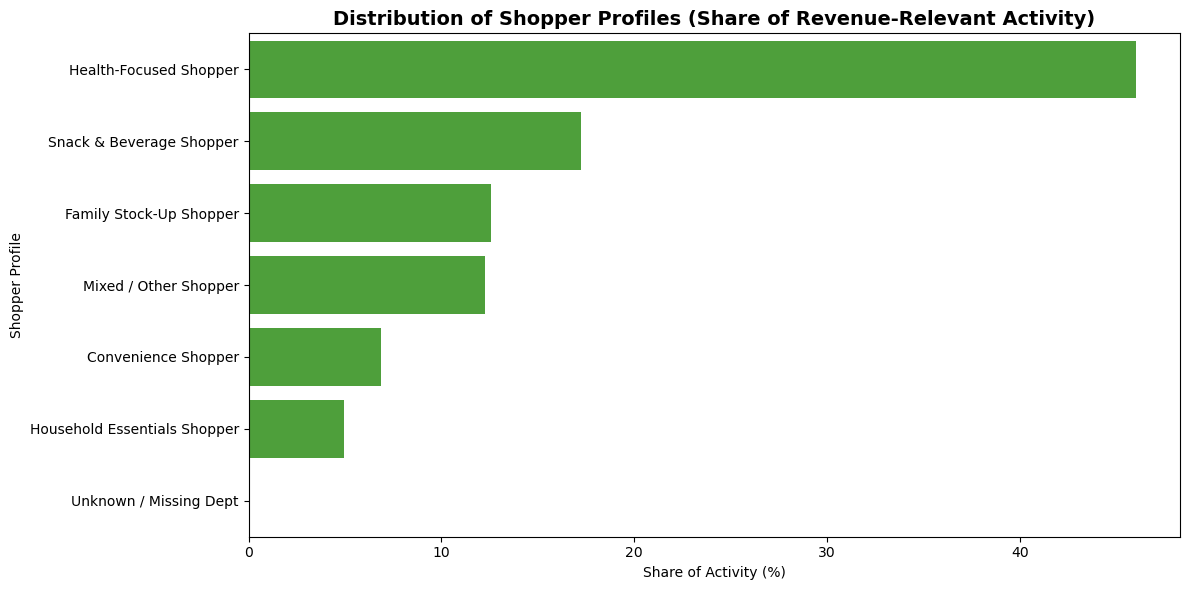

In [177]:
# Instacart-branded shopper profile distribution chart
instacart_green = "#43B02A"

plt.figure(figsize=(12,6))

sns.barplot(
    data=profile_dist,
    y="shopper_profile",
    x="pct_of_activity",
    color=instacart_green)

plt.title("Distribution of Shopper Profiles (Share of Revenue-Relevant Activity)", fontsize=14, weight="bold")
plt.xlabel("Share of Activity (%)")
plt.ylabel("Shopper Profile")

plt.tight_layout()
plt.show()

# Step 7: Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [178]:
# Aggregate max, mean, min by shopper_profile (usage frequency + expenditure)
# Usage frequency (orders per customer proxy)
step7_profile_agg = (df_cfo
    .groupby("shopper_profile")
    .agg(
        # Usage frequency (order count proxy)
        min_order_count=("max_order", "min"),
        mean_order_count=("max_order", "mean"),
        max_order_count=("max_order", "max"),

        # Expenditure (spend proxy)
        min_spend=("prices", "min"),
        mean_spend=("prices", "mean"),
        max_spend=("prices", "max"))
    .reset_index())

display(step7_profile_agg)

,shopper_profile,min_order_count,mean_order_count,max_order_count,min_spend,mean_spend,max_spend
0,Convenience Shopper,5,34.311707,99,1.0,7.822456,15.0
1,Family Stock-Up Shopper,5,32.559835,99,1.0,7.861913,20.0
2,Health-Focused Shopper,5,35.465912,99,1.0,8.109560,15.0
3,Household Essentials Shopper,5,33.597950,99,1.0,7.619092,15.0
4,Mixed / Other Shopper,5,32.552357,99,1.0,9.202263,25.0
5,Snack & Beverage Shopper,5,34.631368,99,1.0,5.916987,15.0
6,Unknown / Missing Dept,5,34.507728,99,NaN,NaN,NaN


# Step 8: 

Compare your customer profiles with regions and departments. Can you identify a link between them? Customers may demonstrate different behaviors across regions, which could make this information important.

In [179]:
# Build dataset
profile_region = (df_cfo
    .groupby(["region", "shopper_profile"])
    .size()
    .reset_index(name="orders"))

profile_region["pct_of_region"] = (
    profile_region.groupby("region")["orders"]
    .transform(lambda x: x / x.sum() * 100))

profile_region = profile_region.sort_values(["region", "pct_of_region"], ascending=[True, False])

display(profile_region.head(20))

,region,shopper_profile,orders,pct_of_region
2,Midwest,Health-Focused Shopper,3346606,46.046383
5,Midwest,Snack & Beverage Shopper,1244122,17.118035
1,Midwest,Family Stock-Up Shopper,918559,12.638572
4,Midwest,Mixed / Other Shopper,892879,12.285237
0,Midwest,Convenience Shopper,496217,6.827514
3,Midwest,Household Essentials Shopper,363131,4.996366
6,Midwest,Unknown / Missing Dept,6388,0.087893
9,Northeast,Health-Focused Shopper,2507620,45.841770
12,Northeast,Snack & Beverage Shopper,956083,17.478141
8,Northeast,Family Stock-Up Shopper,683167,12.488967


In [180]:
# What each person actually buys (department mix)
profile_department = (df_cfo
    .groupby(["shopper_profile", "department"])
    .size()
    .reset_index(name="orders"))

profile_department["pct_of_profile"] = (
    profile_department.groupby("shopper_profile")["orders"]
    .transform(lambda x: x / x.sum() * 100))

profile_department = profile_department.sort_values(["shopper_profile", "pct_of_profile"], ascending=[True, False])

display(profile_department.head(30))

,shopper_profile,department,orders,pct_of_profile
0,Convenience Shopper,bakery,1120828,52.753238
1,Convenience Shopper,deli,1003834,47.246762
2,Family Stock-Up Shopper,frozen,2121732,54.341561
3,Family Stock-Up Shopper,pantry,1782705,45.658439
5,Health-Focused Shopper,produce,9079276,63.685351
4,Health-Focused Shopper,dairy eggs,5177183,36.314649
7,Household Essentials Shopper,household,699858,45.606547
8,Household Essentials Shopper,personal care,424306,27.650082
6,Household Essentials Shopper,babies,410392,26.743371
12,Mixed / Other Shopper,canned goods,1012074,26.590499


_Step 8: Because customer profiles behave consistently across regions but differ strongly by department mix, marketing, promotions, and assortment strategies should prioritize profile-based targeting rather than regional targeting.
Growth opportunities are therefore driven more by expanding profile penetration than by tailoring offers region-by-region._

# Exporting data set and intermediate summary tables

In [ ]:
# Export master data set
df_cfo.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "final_cfo_dataset.pkl"))
df_cfo.to_csv(os.path.join(path, "02 Data", "Prepared Data", "final_cfo_dataset.csv"), index=False)

In [ ]:
# Export the Step 7 summary table created
step7_profile_agg.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "step7_profile_agg.pkl"))

In [ ]:
#Export the step 8 tables created
profile_region.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "profile_region.pkl"))
profile_department.to_pickle(os.path.join(path, "02 Data", "Prepared Data", "profile_department.pkl"))

Final Output

This notebook produces the canonical final analytical dataset used across all segmentation, loyalty, revenue efficiency, and concentration analyses for Achievement 4.

The finalized dataset has been exported to the **Prepared Data** directory in both Pickle and CSV formats and serves as the single source of truth for the final report and all visual analysis in Notebook 2.